# cmapR tutorial

This notebook will walk through some of the basic functionality in the cmapR package, which is largely centered around working with matrix data in [GCT and GCTX format](https://clue.io/help#datasets). We'll be using data from one of CMap's GEO series, [GSE70138](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138), but the steps below are applicable to any GCT or GCTX file.

## Obtaining Data from Gene Expression Omnibus (GEO)

[Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/), or GEO, is a NCBI-maintained public repository of array and sequence genomics data. As of April 2017, we have provided 1.7 million profiles to GEO at the following accessions:
* [GSE70138](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138)
* [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)
* [GSE92743](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92743)

Please note that this does not represent the only data available in GCT and GCTX format; we simply mention it as a public resource for freely available data in these formats, and will use it as an example in this tutorial.
Data can be downloaded from GEO using either using FTP or HTTP; see accession pages above for details.

## Obtaining the cmapR package

cmapR source code can be obtained from [github](https://github.com/cmap/cmapr). To install the package, follow the install instructions in the README file within the cmapR repository.

## Loading the cmapR package

cmapR can be loaded within an R session or script just like any other package.

In [4]:
# load the library
library(cmapR)

Loading required package: rhdf5
Warning message:
“package ‘rhdf5’ was built under R version 3.2.2”Loading required package: data.table


## GCT objects in R

The main class of objects in cmapR is the `GCT` class. The `GCT` object contains a data `matrix` and (optionally) row and column annotations as `data.frame` objects. We can get more information about the class by viewing its help documentatoin.

In [40]:
# access the GCT class help
?`GCT-class`

## Parsing files

You can parse both GCT and GCTX files using the `parse.gctx` method. This method will read the corresponding GCT or GCTX file and return an object of class `GCT` into your R session.

### Parsing the entire file

If the file you are working with fits entirely within your computer's memory, you can read the entire file in one shot. Using the level 5 matrix from GSE70138, that would look like the line below. We've commented it out here because the file is large enough that reading the whole thing is impractical.

In [3]:
# create a variable to store the path to the level 5 GCTX file
ds_path <- "GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"

my_ds <- parse.gctx(ds_path)

### Parsing a subset of a GCTX file

When working with large GCTX files, such as those in the GEO repositories listed above, it is usually not possible to read the entire file into memory all at once. In these cases, it's helpful to identify a subset of the data that is of particular interest and read only those rows or columns. In this example, we'll use the level 5 signature metadata to find all the signatures (columns) pertaining to the compound vorinostat.

In [4]:
# read the column annotations as a data.frame
col_meta_path <- "GSE70138_Broad_LINCS_sig_info_2017-03-06.txt"
col_meta <- read.delim(col_meta_path, sep="\t", stringsAsFactors=F)

# figure out which signatures correspond to vorinostat by searching the 'pert_iname' column
idx <- which(col_meta$pert_iname=="vorinostat")

# and get the corresponding sig_ids
sig_ids <- col_meta$sig_id[idx]

# read only those columns from the GCTX file by using the 'cid' parameter
vorinostat_ds <- parse.gctx(ds_path, cid=sig_ids)

# simply typing the variable name of a GCT object will display the object structure, similar to calling 'str'
vorinostat_ds

reading GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx
done


Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:12328, 1:210] 1.194 -0.3476 0.0692 -1.0203 -2.2573 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:12328] "780" "7849" "2978" "2049" ...
  .. .. ..$ : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ rid    : chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ cid    : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ rdesc  :'data.frame':	12328 obs. of  1 variable:
  .. ..$ id: chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ cdesc  :'data.frame':	210 obs. of  1 variable:
  .. ..$ id: chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ version: chr(0) 
  ..@ src    : chr "GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"

## Creating a GCT object from existing workspace objects
It's also possible to create a GCT object from existing objects in your R workspace. You will minimally need to have a matrix object, but can also optionally include `data.frame`s of row and column annotations.

In [14]:
# initialize a matrix object
# note that you either must assign values to the rownames and colnames of the matrix, or pass them
# as the 'rid' and 'cid' arguments to GCT
mat <- matrix(stats::rnorm(100), ncol=10)
rownames(mat) <- letters[1:10]
colnames(mat) <- LETTERS[1:10]
(my_ds <- new("GCT", mat=mat))

# we can also include the row/column annotations as data.frames
# note these are just arbitrary annotations used to illustrate the function call
rdesc <- data.frame(id=letters[1:10], type=rep(c(1, 2), each=5))
cdesc <- data.frame(id=LETTERS[1:10], type=rep(c(3, 4), each=5))
(my_ds <- new("GCT", mat=mat, rdesc=rdesc, cdesc=cdesc))

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:10, 1:10] 1.075 0.503 -2.385 0.653 -1.134 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:10] "a" "b" "c" "d" ...
  .. .. ..$ : chr [1:10] "A" "B" "C" "D" ...
  ..@ rid    : chr [1:10] "a" "b" "c" "d" ...
  ..@ cid    : chr [1:10] "A" "B" "C" "D" ...
  ..@ rdesc  :'data.frame':	0 obs. of  0 variables
Formal class 'data.frame' [package "methods"] with 4 slots
  .. .. ..@ .Data    : list()
  .. .. ..@ names    : chr(0) 
  .. .. ..@ row.names: int(0) 
  .. .. ..@ .S3Class : chr "data.frame"
  ..@ cdesc  :'data.frame':	0 obs. of  0 variables
Formal class 'data.frame' [package "methods"] with 4 slots
  .. .. ..@ .Data    : list()
  .. .. ..@ names    : chr(0) 
  .. .. ..@ row.names: int(0) 
  .. .. ..@ .S3Class : chr "data.frame"
  ..@ version: chr(0) 
  ..@ src    : chr(0) 

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:10, 1:10] 1.075 0.503 -2.385 0.653 -1.134 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:10] "a" "b" "c" "d" ...
  .. .. ..$ : chr [1:10] "A" "B" "C" "D" ...
  ..@ rid    : chr [1:10] "a" "b" "c" "d" ...
  ..@ cid    : chr [1:10] "A" "B" "C" "D" ...
  ..@ rdesc  :'data.frame':	10 obs. of  2 variables:
  .. ..$ id  : Factor w/ 10 levels "a","b","c","d",..: 1 2 3 4 5 6 7 8 9 10
  .. ..$ type: num [1:10] 1 1 1 1 1 2 2 2 2 2
  ..@ cdesc  :'data.frame':	10 obs. of  2 variables:
  .. ..$ id  : Factor w/ 10 levels "A","B","C","D",..: 1 2 3 4 5 6 7 8 9 10
  .. ..$ type: num [1:10] 3 3 3 3 3 4 4 4 4 4
  ..@ version: chr(0) 
  ..@ src    : chr(0) 

## Adding annotations to a GCT object

When working with `GCT` objects, it's often convenient to have the row and column annotations embedded as the `rdesc` and `cdesc` slots, respectively. If these metadata are stored separatly from the GCTX file itself, you can read them in separately and then apply them to the `GCT` object using the `annotate.gct` function.

In [14]:
# apply the col_meta data.frame as the column anntations to vorinostat_ds
# note that col_meta must have a colum that corresponds to the 'cid' slot of my_ds, aka the 'keyfield'
# note also how the 'cdesc' slot changes after annotating
(vorinostat_ds_annotated <- annotate.gct(vorinostat_ds, col_meta, dim="col", keyfield="sig_id"))

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:12328, 1:210] 1.194 -0.3476 0.0692 -1.0203 -2.2573 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:12328] "780" "7849" "2978" "2049" ...
  .. .. ..$ : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ rid    : chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ cid    : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ rdesc  :'data.frame':	12328 obs. of  1 variable:
  .. ..$ id: chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ cdesc  :'data.frame':	210 obs. of  8 variables:
  .. ..$ id        : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  .. ..$ sig_id    : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  .. ..$ pert_id   : chr [1:210] "BRD-K81418486" "BRD-K81

### Parsing metadata from a GCTX file

In the example above, the signature metadata is stored separately from the GCTX file, and so we could read it in as a `data.frame` using `read.delim` or some equivalent. However, in some cases the metadata may be stored in the GCTX file itself. We can extract the metadata from a GCTX file using the `read.gctx.meta` function and then use this metadata to idenfity the relevant subsets of the matrix, as shown above.

In [6]:
# extract the column metadata, again assuming the GCTX file is in our working directory
col_meta_from_gctx <- read.gctx.meta(ds_path, dim="col")

# we can also extract the row metadata, if desired, by simply changing the 'dim' parameter
row_meta_from_gctx <- read.gctx.meta(ds_path, dim="row")

## Slicing a GCT object

Just as it's possible to read a subset of rows or columns from a GCTX file, it is also possible to extract a subset of rows or columns from a GCT object in memory. This is done with the `subset.gct` function.

In [27]:
# using my_ds_annotated, slice out the columns corresponding to the A375 cell line
# we first need to determine which columns correspond to A375, but we can
# do this using the column annotations
idx <- which(vorinostat_ds_annotated@cdesc$cell_id == "A375")
vorinostat_ds_A375 <- subset.gct(vorinostat_ds_annotated, cid=idx)

# we can check the dimensionality of the any GCT object using the 'dim' function
message("vorinostat_ds_A375:")
dim(vorinostat_ds_A375)

# similarly, we can slice out the first 25 rows of this GCT object using the 'rid' parameter
vorinostat_ds_A375_first_25 <- subset.gct(vorinostat_ds_A375, rid=1:25)

# we can check the dimensionality of the any GCT object using the 'dim' function
message("vorinostat_ds_A375_first_25:")
dim(vorinostat_ds_A375_first_25)

vorinostat_ds_A375:


[1] 12328    18

vorinostat_ds_A375_first_25:


[1] 25 18

## Melting GCT objects

It's often useful to have data stored in long form `data.frame` objects, especially for compatibility with plotting libraries like [`ggplot2`](http://docs.ggplot2.org/current/). It's possible to convert a `GCT` object into this long form by using the `melt.gct` function, which relies on the `melt` function in the [`data.table`](https://cran.r-project.org/web/packages/data.table/) package.

melting GCT object...
done


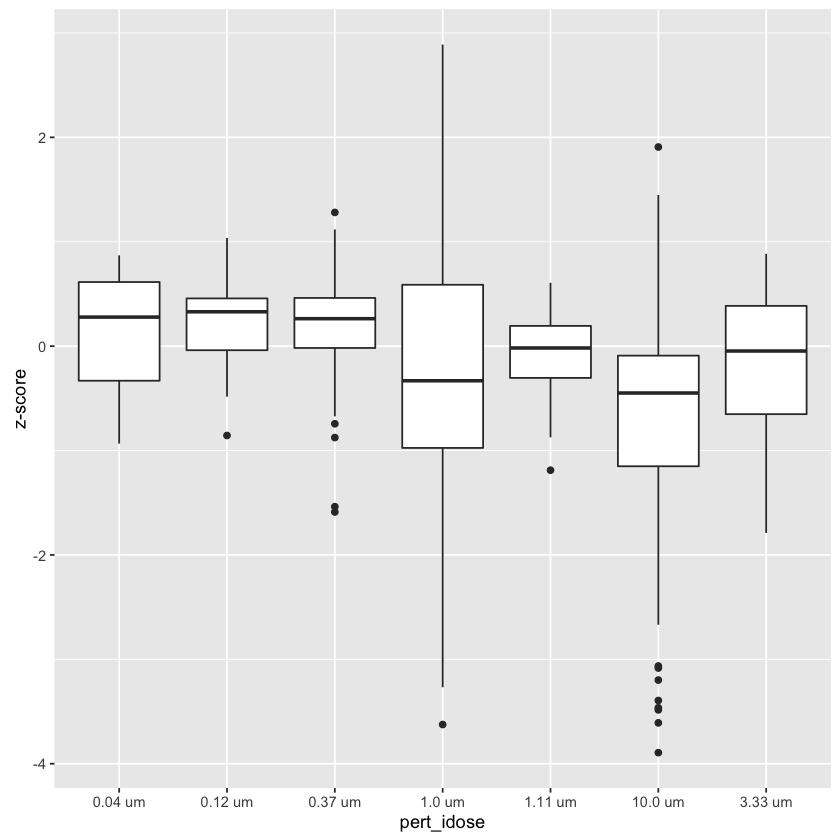

In [22]:
# convert my_ds_A375_first_25 to long form so we can plot the z-scores
# of these 25 genes grouped by dose
(vorinostat_ds_A375_first_25_melted <- melt.gct(vorinostat_ds_A375_first_25))
library(ggplot2)
ggplot(vorinostat_ds_A375_first_25_melted) + geom_boxplot(aes(x=pert_idose, y=value)) + ylab("z-score")

## Merging two GCT objects

You can combine two independent `GCT` objects using the `merge.gct` function. Note that it is important to specify which dimension (row or column) you wish to merge on and that the two `GCT` objects in question share one common dimension.

In [31]:
# extract the vorinostat signatures in PC3 as another separate dataset
idx <- which(vorinostat_ds_annotated@cdesc$cell_id == "PC3")
vorinostat_ds_PC3 <- subset.gct(vorinostat_ds_annotated, cid=idx)
dim(vorinostat_ds_PC3)

# merge the A375 and PC3 GCT objects together by columns, because
# the two objects share common rows. this is equivalent to a 'cbind' operation
# on matrices
vorinostat_ds_A375_PC3 <- merge.gct(vorinostat_ds_A375, vorinostat_ds_PC3, dim="column")
table(vorinostat_ds_A375_PC3@cdesc$cell_id)

[1] 12328    15

appending columns...



A375  PC3 
  18   15 

## Math operations on GCT objects

The `@mat` slot of a GCT object is a base R matrix object, so it's possible to perform standard math operations on this matrix. Below are a few simple examples, but these can easily be extended, particulary through use of the `apply` function.

In [34]:
# compute the row and column means
row_means <- rowMeans(vorinostat_ds_annotated@mat)
col_means <- colMeans(vorinostat_ds_annotated@mat)
message("means:")
head(row_means)
head(col_means)

# using 'apply', compute the max of each row and column
row_max <- apply(vorinostat_ds_annotated@mat, 1, max)
col_max <- apply(vorinostat_ds_annotated@mat, 2, max)
message("maxes:")
head(row_max)
head(col_max)

means:


780        7849        2978        2049        2101        8717 
-0.72086485 -0.15359941  0.15368198 -0.26546231 -0.27307698 -0.06614056

LJP007_ASC_24H:A03    LJP007_HUES3_24H:A03   LJP007_MNEU.E_24H:A03 
             0.14663278              1.18300401              0.28148640 
     LJP007_NEU_24H:A03 LJP007_NPC.CAS9_24H:A03      LJP007_NPC_24H:A03 
             0.05829414             -0.02963328             -0.12967090

maxes:


780      7849      2978      2049      2101      8717 
 5.040502 10.000000  2.583400  2.702300  3.572040  6.637400

LJP007_ASC_24H:A03    LJP007_HUES3_24H:A03   LJP007_MNEU.E_24H:A03 
               9.453033               10.000000                9.581500 
     LJP007_NEU_24H:A03 LJP007_NPC.CAS9_24H:A03      LJP007_NPC_24H:A03 
               7.502289               10.000000               10.000000

### GCT-specific math functions

cmapR also contains a handful of math functions designed specifically for operating on `GCT` objects.

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:210, 1:12328] 1.19 -3.1 -2.9 -2.95 -10 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  .. .. ..$ : chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ rid    : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  ..@ cid    : chr [1:12328] "780" "7849" "2978" "2049" ...
  ..@ rdesc  :'data.frame':	210 obs. of  8 variables:
  .. ..$ id        : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  .. ..$ sig_id    : chr [1:210] "LJP007_ASC_24H:A03" "LJP007_HUES3_24H:A03" "LJP007_MNEU.E_24H:A03" "LJP007_NEU_24H:A03" ...
  .. ..$ pert_id   : chr [1:210] "BRD-K81418486" "BRD-K81418486" "BRD-K81418486" "BRD-K81418486" ...
  .. ..$ pert_iname: chr [1:210] "vorinostat" "vorinostat" "vorinostat" "vorinost

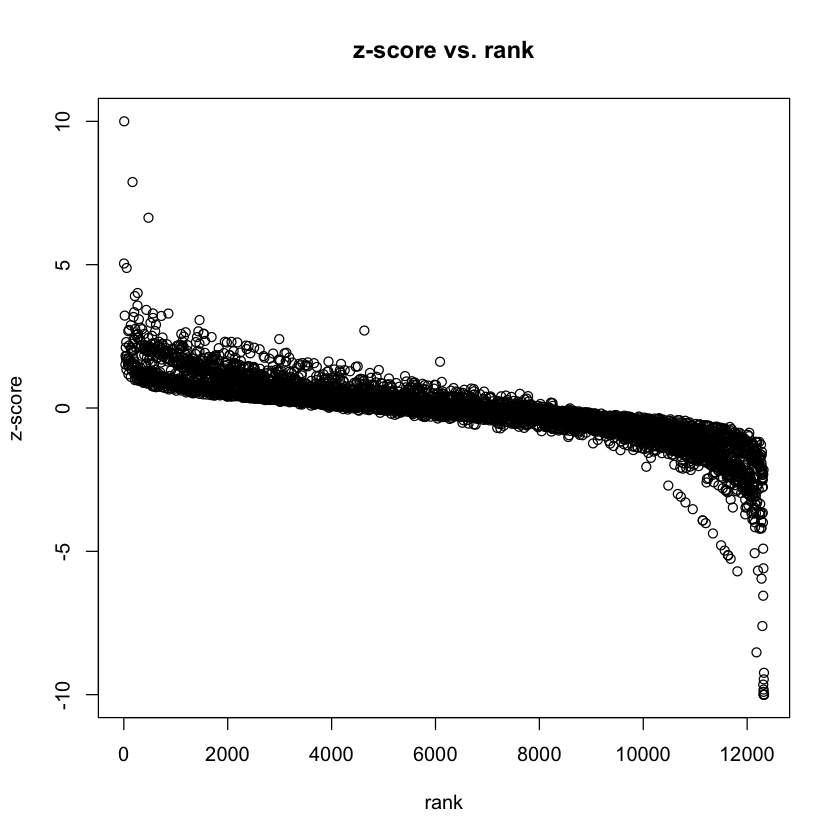

In [38]:
# transposing a GCT object - also swaps row and column annotations
(vorinostat_ds_transpose <- transpose.gct(vorinostat_ds_annotated))

# converting a GCT object's matrix to ranks
# the 'dim' option controls the direction along which the ranks are calculated
vorinostat_ds_rank_by_column <- rank.gct(vorinostat_ds_annotated, dim="col")

# plot z-score vs rank for the first 25 genes (rows)
plot(vorinostat_ds_rank_by_column@mat[1:25, ], vorinostat_ds_annotated@mat[1:25, ],
    xlab="rank", ylab="z-score", main="z-score vs. rank")

## Writing GCT objects to disk

`GCT` objects can be written to disk either in GCT or GCTX format using the `write.gct` and `write.gctx` functions, respectively.

In [39]:
# write the vorinostat_ds_A375_first_25 dataset in both GCT and GCTX format
write.gct(vorinostat_ds_A375_first_25, "vorinostat_ds_A375_first_25")
write.gctx(vorinostat_ds_A375_first_25, "vorinostat_ds_A375_first_25")

# write.gctx can also compress the dataset upon write,
# which can be controlled using the 'compression_level' option.
# the higher the value, the greater the compression, but the
# longer the read/write time
write.gctx(vorinostat_ds_A375_first_25, "vorinostat_ds_A375_first_25_compressed",
          compression_level=9)

Saving file to ./vorinostat_ds_A375_first_25_n18x25.gct
Dimensions of matrix: [25x18]
Setting precision to 4
Saved.


writing ./vorinostat_ds_A375_first_25_n18x25.gctx
chunk sizes:	25	18
writing ./vorinostat_ds_A375_first_25_compressed_n18x25.gctx
chunk sizes:	25	18
